In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
from copy import deepcopy
from rxnpredict.ts.desc import sel_satisfy_ts_data,vec_ts_pair_in_dataset,get_diff_ts_desc
from rxnpredict.models.utils import get_model
from rxnpredict.evaluate.eval import get_predict
from rxnpredict.descriptors.desc import vect_columns_in_dataset,sel_high_corr_desc,reduce_desc_with_corr_matrix
from rxnpredict.descriptors.utils import process_desc,maxminscale
from rdkit import RDLogger
from sklearn.metrics import mean_absolute_error
from rxnpredict.utils.convert import ddG2ee
from rdkit import Chem
import seaborn as sns
sns.set_theme(style="darkgrid")
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model_name = "GradientBoostingRegressor"
desc_name = "SPOC"
merge_method = "delta"
dist_type = "euclidean"
descriptor_pearsonr_threshold = 0.95
descriptor_target_pearsonr_threshold = 0.2
base_rct_keys = ["Reactant1","Reactant2"]
target_rct_keys = ["Reactant1","Reactant2"]
base_sol_keys = ["Solvents"]
target_sol_keys = ["Solvents"]
base_rgt_keys = ["Reagents"]
target_rgt_keys = ["Reagents"]
base_ts_key = ["Reactant2","Reagent5"]
target_ts_key = ["Reactant2","Reagent2"]
extsol_ts_key = ["Reactant2","Reagent2"]
extlig_ts_key = ["Reactant2","Reagent2"]
selection_inf = {
            "type": "loo",
            "fold": 10,
            "metric": [
                "r2",
                "mae"
            ]}

In [5]:
base_data_file = "../data/base_data.csv"
target_data_file = "../data/target_data.csv"
extsol_data_file = "../data/extsol.csv"
extlig_data_file = "../data/extlig.csv"
base_data = pd.read_csv(base_data_file)
target_data = pd.read_csv(target_data_file)
extsol_data = pd.read_csv(extsol_data_file)
extlig_data = pd.read_csv(extlig_data_file)

base_data_clean = base_data.dropna(axis=1, how='all')
target_data_clean = target_data.dropna(axis=1, how='all')
extsol_data_clean = extsol_data.dropna(axis=1, how='all')
extlig_data_clean = extlig_data.dropna(axis=1, how='all')

# fill NaN with empty string
for key in target_rct_keys + target_sol_keys + target_rgt_keys:
    target_data_clean[key] = target_data_clean[key].fillna('')
for key in base_rct_keys + base_sol_keys + base_rgt_keys:
    base_data_clean[key] = base_data_clean[key].fillna('')
## Drop rows with missing target values
target_data_clean = target_data_clean.dropna(subset=target_rct_keys+target_ts_key)
base_data_clean = base_data_clean.dropna(subset=base_rct_keys+base_ts_key)

clear_smiles_tsdesc_map = np.load("../desc/clear_smiles_tsdesc_map_for_oos.npy",allow_pickle=True).item()
print(f"base data shape: {base_data_clean.shape}", f"target data shape: {target_data_clean.shape}", f"extsol data shape: {extsol_data_clean.shape}", f"extlig data shape: {extlig_data_clean.shape}")

base data shape: (466, 16) target data shape: (68, 12) extsol data shape: (10, 13) extlig data shape: (4, 13)


In [6]:
oos_sol_smi_set = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in set(extsol_data_clean["Solvents"].to_list())]
sol_smi_in_train_set = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in set(target_data_clean["Solvents"].to_list())]
for smi in oos_sol_smi_set:
    if smi in sol_smi_in_train_set:
        print(f"Solvent {smi} is in both train and test set")

oos_lig_smi_set = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in set(extlig_data_clean["Reagent2"].to_list())]
lig_smi_in_train_set = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in set(target_data_clean["Reagent2"].to_list())]
for smi in oos_lig_smi_set:
    if smi in lig_smi_in_train_set:
        print(f"Ligand {smi} is in both train and test set")

In [7]:
sel_target_data_clean = target_data_clean.iloc[sel_satisfy_ts_data(target_data_clean,target_ts_key,clear_smiles_tsdesc_map)]
sel_base_data_clean = base_data_clean.iloc[sel_satisfy_ts_data(base_data_clean,base_ts_key,clear_smiles_tsdesc_map)]
sel_extsol_data_clean = extsol_data_clean.iloc[sel_satisfy_ts_data(extsol_data_clean,extsol_ts_key,clear_smiles_tsdesc_map)]
sel_extlig_data_clean = extlig_data_clean.iloc[sel_satisfy_ts_data(extlig_data_clean,extlig_ts_key,clear_smiles_tsdesc_map)]
print(f"Dataset size: target = {target_data_clean.shape} (without ts constraint) {sel_target_data_clean.shape} (with ts constraint), base = {base_data_clean.shape} (without ts constraint) {sel_base_data_clean.shape} (with ts constraint)")
print(f"Dataset size: extsol = {extsol_data_clean.shape} (without ts constraint) {sel_extsol_data_clean.shape} (with ts constraint), extlig = {extlig_data_clean.shape} (without ts constraint) {sel_extlig_data_clean.shape} (with ts constraint)")
# perform vectorization for target values with ts descriptors
target_ts_desc_inf = vec_ts_pair_in_dataset(sel_target_data_clean,target_ts_key,clear_smiles_tsdesc_map)
target_ts_desc,target_ts_desc_names = target_ts_desc_inf[:,0,:].astype(np.float32),target_ts_desc_inf[:,1,:]
base_ts_desc_inf = vec_ts_pair_in_dataset(sel_base_data_clean,base_ts_key,clear_smiles_tsdesc_map)
base_ts_desc,base_ts_desc_names = base_ts_desc_inf[:,0,:].astype(np.float32),base_ts_desc_inf[:,1,:]
extsol_ts_desc_inf = vec_ts_pair_in_dataset(sel_extsol_data_clean,extsol_ts_key,clear_smiles_tsdesc_map)
extsol_ts_desc,extsol_ts_desc_names = extsol_ts_desc_inf[:,0,:].astype(np.float32),extsol_ts_desc_inf[:,1,:]
extlig_ts_desc_inf = vec_ts_pair_in_dataset(sel_extlig_data_clean,extlig_ts_key,clear_smiles_tsdesc_map)
extlig_ts_desc,extlig_ts_desc_names = extlig_ts_desc_inf[:,0,:].astype(np.float32),extlig_ts_desc_inf[:,1,:]
print(f"target TS descriptor shape: {target_ts_desc.shape}, name shape: {target_ts_desc_names.shape}, base TS descriptor shape: {base_ts_desc.shape}, name shape: {base_ts_desc_names.shape}")


# calculate difference descriptors between R/S TS
target_ts_diff_desc,target_ts_diff_desc_names = get_diff_ts_desc(target_ts_desc,target_ts_desc_names[0])
base_ts_diff_desc,base_ts_diff_desc_names = get_diff_ts_desc(base_ts_desc,base_ts_desc_names[0])
extsol_ts_diff_desc,extsol_ts_diff_desc_names = get_diff_ts_desc(extsol_ts_desc,extsol_ts_desc_names[0])
extlig_ts_diff_desc,extlig_ts_diff_desc_names = get_diff_ts_desc(extlig_ts_desc,extlig_ts_desc_names[0])
target_ts_desc = np.concatenate([target_ts_desc,target_ts_diff_desc],axis=1)                                             ## full TS descriptors
base_ts_desc = np.concatenate([base_ts_desc,base_ts_diff_desc],axis=1)                                                   ## full TS descriptors
extsol_ts_desc = np.concatenate([extsol_ts_desc,extsol_ts_diff_desc],axis=1)                                             ## full TS descriptors
extlig_ts_desc = np.concatenate([extlig_ts_desc,extlig_ts_diff_desc],axis=1)                                             ## full TS descriptors
target_ts_desc_names = np.concatenate([target_ts_desc_names[0],target_ts_diff_desc_names],axis=0)                        ## full TS descriptor names
base_ts_desc_names = np.concatenate([base_ts_desc_names[0],base_ts_diff_desc_names],axis=0)                              ## full TS descriptor names
target_ddG = sel_target_data_clean["ddG"].to_numpy()
base_ddG = sel_base_data_clean["ddG"].to_numpy()
extsol_ddG = sel_extsol_data_clean["ddG"].to_numpy()
extlig_ddG = sel_extlig_data_clean["ddG"].to_numpy()
print(f"Full target TS descriptor shape: {target_ts_desc.shape}, name shape: {target_ts_desc_names.shape}, base TS descriptor shape: {base_ts_desc.shape}, name shape: {base_ts_desc_names.shape}")

Dataset size: target = (68, 12) (without ts constraint) (55, 12) (with ts constraint), base = (466, 16) (without ts constraint) (446, 16) (with ts constraint)
Dataset size: extsol = (10, 13) (without ts constraint) (10, 13) (with ts constraint), extlig = (4, 13) (without ts constraint) (4, 13) (with ts constraint)
target TS descriptor shape: (55, 114), name shape: (55, 114), base TS descriptor shape: (446, 114), name shape: (446, 114)
Full target TS descriptor shape: (55, 171), name shape: (171,), base TS descriptor shape: (446, 171), name shape: (171,)


In [8]:
extsol_merg_rct_desc,_,_ = vect_columns_in_dataset(extsol_data_clean,["Reactant1","Reactant2"],{'descriptor':desc_name},verbose=True)
extsol_merg_sol_desc,_,_ = vect_columns_in_dataset(extsol_data_clean,["Solvents"],{'descriptor':desc_name},verbose=True)
extsol_merg_reag_desc,_,_ = vect_columns_in_dataset(extsol_data_clean,["Reagents"],{'descriptor':desc_name},verbose=True)
extsol_merg_rxn_desc = np.concatenate([extsol_merg_rct_desc,extsol_merg_sol_desc,extsol_merg_reag_desc],axis=1)

extlig_merg_rct_desc,_,_ = vect_columns_in_dataset(extlig_data_clean,["Reactant1","Reactant2"],{'descriptor':desc_name},verbose=True)
extlig_merg_sol_desc,_,_ = vect_columns_in_dataset(extlig_data_clean,["Solvents"],{'descriptor':desc_name},verbose=True)
extlig_merg_reag_desc,_,_ = vect_columns_in_dataset(extlig_data_clean,["Reagents"],{'descriptor':desc_name},verbose=True)
extlig_merg_rxn_desc = np.concatenate([extlig_merg_rct_desc,extlig_merg_sol_desc,extlig_merg_reag_desc],axis=1)
merg_desc_names = np.array([f"Reactant 1 {desc_name} {i}" for i in range(extlig_merg_rct_desc.shape[1]//2)] + \
                           [f"Reactant 2 {desc_name} {i}" for i in range(extlig_merg_rct_desc.shape[1]//2)] + \
                           [f"Solvent {desc_name} {i}" for i in range(extlig_merg_sol_desc.shape[1])] + \
                           [f"Reagent {desc_name} {i}" for i in range(extlig_merg_reag_desc.shape[1])])

In [9]:
pregen_desc_map = np.load("../desc/desc_for_other_components.npy",allow_pickle=True).item()

# descriptor process
concat_ts_desc,concat_ts_desc_process_ret_idx = process_desc(np.concatenate([target_ts_desc,base_ts_desc],axis=0),return_idx=True)                                                                              # descriptor process
concat_ts_desc,concat_ts_desc_max,concat_ts_desc_min = maxminscale(concat_ts_desc,return_scale=True)                                                                                                            # descriptor process
# remove correlated descriptors
concat_ts_desc,concat_ts_desc_high_tgt_corr_idx = sel_high_corr_desc(concat_ts_desc,np.concatenate([target_ddG,base_ddG]),threshold=descriptor_target_pearsonr_threshold,return_idx=True)                       # descriptor elimination
concat_ts_desc,concat_ts_desc_high_corr_idx = reduce_desc_with_corr_matrix(concat_ts_desc,threshold=descriptor_pearsonr_threshold,ret_idx=True)                                                                 # descriptor elimination

target_ts_desc_ = concat_ts_desc[:target_ts_desc.shape[0]]
base_ts_desc_ = concat_ts_desc[target_ts_desc.shape[0]:]

extsol_ts_desc_ = ((extsol_ts_desc[:,concat_ts_desc_process_ret_idx]-concat_ts_desc_min) / (concat_ts_desc_max-concat_ts_desc_min))[:,concat_ts_desc_high_tgt_corr_idx][:,concat_ts_desc_high_corr_idx]
extlig_ts_desc_ = ((extlig_ts_desc[:,concat_ts_desc_process_ret_idx]-concat_ts_desc_min) / (concat_ts_desc_max-concat_ts_desc_min))[:,concat_ts_desc_high_tgt_corr_idx][:,concat_ts_desc_high_corr_idx]
base_ts_desc_names_ = base_ts_desc_names[concat_ts_desc_process_ret_idx][concat_ts_desc_high_tgt_corr_idx][concat_ts_desc_high_corr_idx]
target_ts_desc_names_ = target_ts_desc_names[concat_ts_desc_process_ret_idx][concat_ts_desc_high_tgt_corr_idx][concat_ts_desc_high_corr_idx]
print(f"target_ts_desc shape: {target_ts_desc.shape}, base_ts_desc shape: {base_ts_desc.shape}")
print(f"target_ts_desc_ shape: {target_ts_desc_.shape},  base_ts_desc_ shape: {base_ts_desc_.shape}")


target_merg_rxn_desc = pregen_desc_map[desc_name]["target"]
base_merg_rxn_desc = pregen_desc_map[desc_name]["base"]
concat_merge_rxn_desc, concat_merge_rxn_desc_process_ret_idx = process_desc(np.concatenate([target_merg_rxn_desc,base_merg_rxn_desc],axis=0),return_idx=True)                                                               # descriptor process
concat_merge_rxn_desc,concat_merge_rxn_desc_max,concat_merge_rxn_desc_min = maxminscale(concat_merge_rxn_desc,return_scale=True)                                                                                            # descriptor process
concat_merge_rxn_desc,concat_merge_rxn_desc_high_tgt_corr_idx = sel_high_corr_desc(concat_merge_rxn_desc,np.concatenate([target_ddG,base_ddG]),threshold=descriptor_target_pearsonr_threshold,return_idx=True)              # descriptor elimination
concat_merge_rxn_desc,concat_merge_rxn_desc_high_corr_idx = reduce_desc_with_corr_matrix(concat_merge_rxn_desc,threshold=descriptor_pearsonr_threshold,ret_idx=True)                                                        # descriptor process

target_merg_rxn_desc_ = concat_merge_rxn_desc[:target_merg_rxn_desc.shape[0]]
base_merg_rxn_desc_ = concat_merge_rxn_desc[target_merg_rxn_desc.shape[0]:]
extsol_merg_rxn_desc_ = ((extsol_merg_rxn_desc[:,concat_merge_rxn_desc_process_ret_idx]-concat_merge_rxn_desc_min) / (concat_merge_rxn_desc_max-concat_merge_rxn_desc_min))[:,concat_merge_rxn_desc_high_tgt_corr_idx][:,concat_merge_rxn_desc_high_corr_idx]
extlig_merg_rxn_desc_ = ((extlig_merg_rxn_desc[:,concat_merge_rxn_desc_process_ret_idx]-concat_merge_rxn_desc_min) / (concat_merge_rxn_desc_max-concat_merge_rxn_desc_min))[:,concat_merge_rxn_desc_high_tgt_corr_idx][:,concat_merge_rxn_desc_high_corr_idx]
merg_desc_names_ = merg_desc_names[concat_merge_rxn_desc_process_ret_idx][concat_merge_rxn_desc_high_tgt_corr_idx][concat_merge_rxn_desc_high_corr_idx]


print(f"{desc_name} target_merg_rxn_desc shape: {target_merg_rxn_desc.shape}, base_merg_rxn_desc shape: {base_merg_rxn_desc.shape}")
print(f"{desc_name} target_merg_rxn_desc_ shape: {target_merg_rxn_desc_.shape},  base_merg_rxn_desc_ shape: {base_merg_rxn_desc_.shape}")

target_full_rxn_desc = np.concatenate([target_merg_rxn_desc_,target_ts_desc_],axis=1)                       # TS + other component descriptors
base_full_rxn_desc = np.concatenate([base_merg_rxn_desc_,base_ts_desc_],axis=1)                             # TS + other component descriptors
extsol_full_rxn_desc = np.concatenate([extsol_merg_rxn_desc_,extsol_ts_desc_],axis=1)                     # TS + other component descriptors
extlig_full_rxn_desc = np.concatenate([extlig_merg_rxn_desc_,extlig_ts_desc_],axis=1)                     # TS + other component descriptors

full_rxn_desc_std, full_rxn_desc_process_ret_idx = process_desc(np.concatenate([target_full_rxn_desc,base_full_rxn_desc],axis=0),return_idx=True)
full_rxn_desc_std, full_rxn_desc_max, full_rxn_desc_min = maxminscale(full_rxn_desc_std,return_scale=True)

target_full_rxn_desc_ = full_rxn_desc_std[:target_full_rxn_desc.shape[0]]
base_full_rxn_desc_ = full_rxn_desc_std[target_full_rxn_desc.shape[0]:]
extsol_full_rxn_desc_ = ((extsol_full_rxn_desc[:,full_rxn_desc_process_ret_idx]-full_rxn_desc_min) / (full_rxn_desc_max-full_rxn_desc_min))
extlig_full_rxn_desc_ = ((extlig_full_rxn_desc[:,full_rxn_desc_process_ret_idx]-full_rxn_desc_min) / (full_rxn_desc_max-full_rxn_desc_min))
tot_base_desc_names = np.concatenate([merg_desc_names_,base_ts_desc_names_],axis=0)[full_rxn_desc_process_ret_idx]
tot_target_desc_names = np.concatenate([merg_desc_names_,target_ts_desc_names_],axis=0)[full_rxn_desc_process_ret_idx]

target_ts_desc shape: (55, 171), base_ts_desc shape: (446, 171)
target_ts_desc_ shape: (55, 67),  base_ts_desc_ shape: (446, 67)
SPOC target_merg_rxn_desc shape: (55, 9032), base_merg_rxn_desc shape: (446, 9032)
SPOC target_merg_rxn_desc_ shape: (55, 193),  base_merg_rxn_desc_ shape: (446, 193)


In [ ]:
extlig_ddG_truth = deepcopy(extlig_ddG)
extsol_ddG_truth = deepcopy(extsol_ddG)
model = get_model(model_name,model_params={"n_estimators":50,"random_state":1024})
exttot_ddG_pred = get_predict(model,
                       base_full_rxn_desc_,base_ddG,
                       target_full_rxn_desc_,target_ddG,
                       np.concatenate([extlig_full_rxn_desc_,extsol_full_rxn_desc_],axis=0),
                       merge_method=merge_method,simi_eval=True,dist_type=dist_type,topk=150,base_simi_X=None,dest_simi_X=None,verbose=True)
exttot_ddG_truth = np.concatenate([extlig_ddG_truth,extsol_ddG_truth],axis=0)
extlig_ddG_pred = exttot_ddG_pred[:len(extlig_ddG)]
extsol_ddG_pred = exttot_ddG_pred[len(extlig_ddG):]
exttot_ee_truth = ddG2ee(exttot_ddG_truth,60+273.15) * 100
exttot_ee_pred = ddG2ee(exttot_ddG_pred,60+273.15) * 100
extlig_ee_truth = exttot_ee_truth[:len(extlig_ddG)]
extsol_ee_truth = exttot_ee_truth[len(extlig_ddG):]
extlig_ee_pred = exttot_ee_pred[:len(extlig_ddG)]
extsol_ee_pred = exttot_ee_pred[len(extlig_ddG):]

Evalutaion process: merge method delta, similarity evaluation True, distance type euclidean, topk 150
14 times model fitting


In [11]:
print(f"MAE for all OOS {mean_absolute_error(exttot_ee_truth,exttot_ee_pred):.1f}%, for ligand OOS: {mean_absolute_error(extlig_ee_truth,extlig_ee_pred):.1f}%, for solvent OOS: {mean_absolute_error(extsol_ee_truth,extsol_ee_pred):.1f}%")

MAE for all OOS 12.8%, for ligand OOS: 5.0%, for solvent OOS: 15.9%


Text(0, 0.5, 'ee (%)')

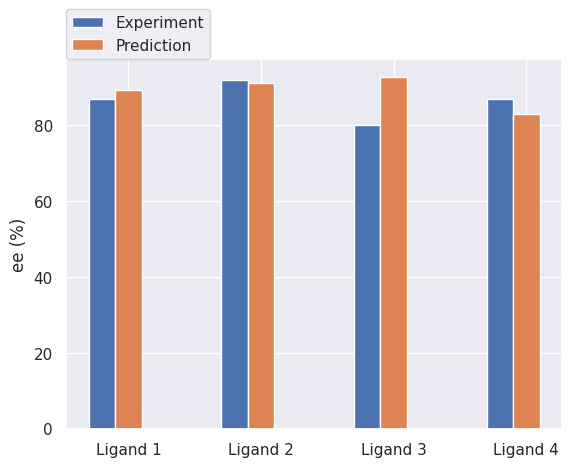

In [12]:
plt.bar(list(range(len(extlig_ee_truth))),extlig_ee_truth,width=0.2,label="Experiment")
plt.bar(np.array(list(range(len(extlig_ee_pred))))+0.2,extlig_ee_pred,width=0.2,label="Prediction")
plt.xticks([0.2,1.2,2.2,3.2],["Ligand 1","Ligand 2","Ligand 3", "Ligand 4"])
plt.legend(loc=(0,1))
plt.ylabel("ee (%)")

Text(0, 0.5, 'ee (%)')

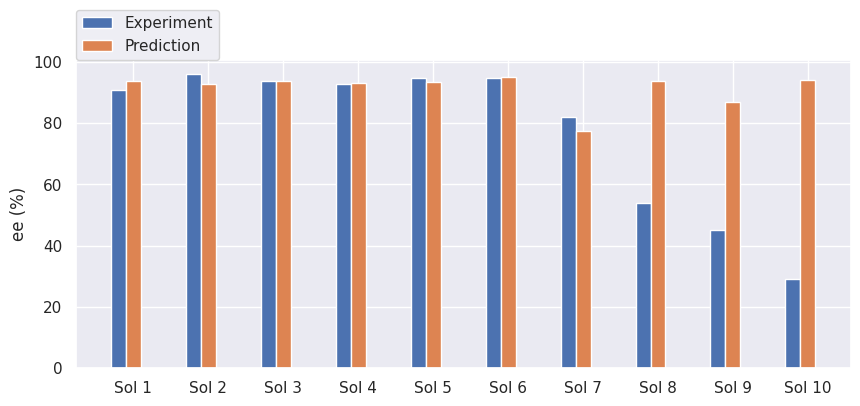

In [13]:
plt.figure(figsize=(10,4))
plt.bar(list(range(len(extsol_ee_truth))),extsol_ee_truth,width=0.2,label="Experiment")
plt.bar(np.array(list(range(len(extsol_ee_pred))))+0.2,extsol_ee_pred,width=0.2,label="Prediction")
plt.xticks([0.2,1.2,2.2,3.2,4.2,5.2,6.2,7.2,8.2,9.2],["Sol 1","Sol 2","Sol 3", "Sol 4","Sol 5","Sol 6","Sol 7", "Sol 8","Sol 9","Sol 10"])
plt.legend(loc=(0,1))
plt.ylabel("ee (%)")